In [124]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
import csv
import os
import time
import math

In [3]:
# MOB subtractor
subtractor = cv2.createBackgroundSubtractorMOG2(detectShadows=False)

In [8]:
# kp and des methods

sift = cv2.xfeatures2d.SIFT_create()
def siftKpAndDes(frame):
    return sift.detectAndCompute(frame,None)

surf = cv2.xfeatures2d.SURF_create()
def surfKpAndDes(frame):
    return surf.detectAndCompute(frame,None)

star = cv2.xfeatures2d.StarDetector_create()
def fastKp(frame):
    return star.detect(frame,None)

brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()
def briefDes(frame, kps):
    return brief.compute(frame, kps)

orb = cv2.ORB_create()
def orbKpAndDes(frame):
    return orb.detectAndCompute(frame,None)

In [206]:
# matcher methods

FLANN_INDEX_KDTREE = 1
FLANN_KDTREES = 5

FLANN_INDEX_LSH = 6
TABLE_NUMBER = 6 #12
KEY_SIZE = 12 #20
MULTI_PROBE_LEVEL = 1 #2
SEARCH_CHECKS = 50

#BF matching
bf_orb = cv2.BFMatcher(cv2.NORM_HAMMING)
bf_sift = cv2.BFMatcher()
def bfMatcher(des1, des2, feature_type = 'SIFT', ratio = 0.7):

    if feature_type is 'ORB': 
        matches = bf_orb.knnMatch(des1,des2,k=2)
    else:
        matches = bf_sift.knnMatch(des1, des2, k=2)
    # filter using ratio
    good = []
    for pair in matches:
        try:
            m,n = pair
            if m.distance < ratio*n.distance:
                good.append(m)
        except ValueError:
            print('Missing Match pair!')
            passq
    return good, matches


#FLANN-based
search_params = dict(checks = SEARCH_CHECKS)
flann_orb = cv2.FlannBasedMatcher(dict(algorithm = FLANN_INDEX_LSH,
                   table_number = TABLE_NUMBER,
                   key_size = KEY_SIZE,
                   multi_probe_level = MULTI_PROBE_LEVEL),
                   search_params)
flann_sift = cv2.FlannBasedMatcher(dict(algorithm = FLANN_INDEX_KDTREE, trees = FLANN_KDTREES), 
                                   search_params )
def flannMatcher(des1, des2, feature_type = 'SIFT', ratio=0.7):
    
    if feature_type is 'ORB': 
        matches = flann_orb.knnMatch(des1, des2, k=2)
    else:
        matches = flann_sift.knnMatch(des1, des2, k=2)
    # filter using ratio
    good = []
    for pair in matches:
        try:
            m,n = pair
            if m.distance < ratio*n.distance:
                good.append(m)
        except ValueError:
            print('Missing Match pair!')
            pass
    return good, matches
        

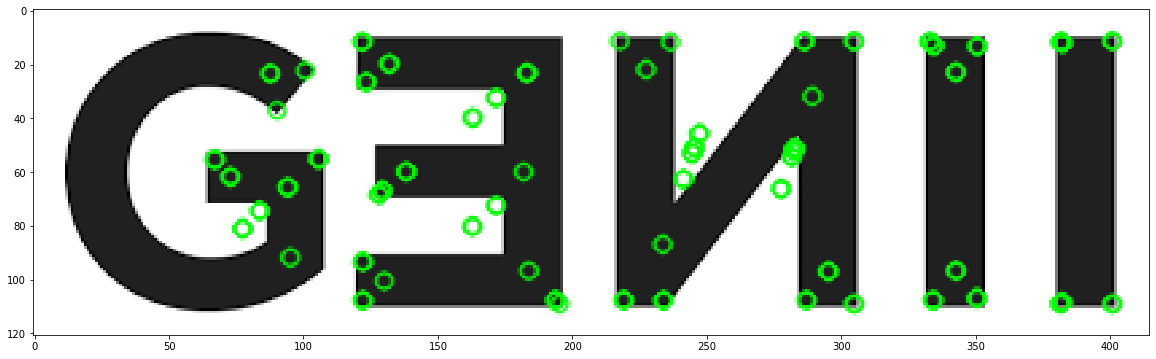

111


In [213]:
# preprocess kp/des for query image(s)

img1 = cv2.imread('logos/genii.jpg',0)          # queryImage
# find the keypoints and descriptors
kp1, des1 = siftKpAndDes(img1)

img1kps = cv2.drawKeypoints(img1, kp1, None, color=(0,255,0), flags=0)
plt.figure(figsize=(20,20))
plt.imshow(img1kps), plt.show()

print(len(kp1))

In [211]:
# encoding params for quality when saving sample jpeg screenshots
encoding_params = [int(cv2.IMWRITE_JPEG_QUALITY), 10]

def runMatching(query, video, output_dir="outputs", chain = 3, feature_ext = 'ORB', matcher = 'FLANN',
               frame_interval = 1, ratio = 0.7, min_matches = 15, fps=30):
    print(chain)
    print(feature_ext)
    print(matcher)
    print(frame_interval)
    print(ratio)
    print(min_matches)
    
    positives = dict() # dict of frame numbers of positive indentifications
    n_pos = 0 # total count of positives
    errors = [] # list of error frames to analyze later (hopefully should be empty!)
    
    cap = cv2.VideoCapture(video)
    img_chain = [] # list of past images in the current running chain of positive frames, up to the chain parameter
    
    # preprocess kp/des for query image(s)
    img1 = cv2.imread(query, 0)
    if feature_ext is 'ORB':     
        kp1, des1 = orbKpAndDes(img1)
    elif feature_ext is 'SIFT':
        kp1, des1 = siftKpAndDes(img1)
    else:
        # no features or matching
        kp1, des1 = [], []
    
    
    # frame number tracker
    frame_n = 0
    
    # start time for running speed measure
    start_t = time.process_time()
    delta = ''
    
    while(True):
        for i in range(frame_interval - 1):
            #skip i number of frames
            cap.grab()

        # Capture frame-by-frame and covert to grayscale
        ret, frame = cap.read()
        if not ret:
            print("Analysis finished!")
            # TODO: post-processing of CSV and image files
            with open(os.path.join(output_dir,'results.csv'), 'w', newline='') as file:
                writer = csv.writer(file)
                writer.writerow(['SUMMARY OF PARAMS'])
                writer.writerow(['Query Image', 'Video', 'Chain Length', 'Feature Extractor', 'Matcher', 
                                 'Frame Interval', 'Pass Ratio', 'Match Thresh'])
                writer.writerow([query, video, chain, feature_ext, matcher, frame_interval, ratio, min_matches])
                writer.writerow(['MATCHES'])
                writer.writerow(['Frame Num', 'Img Name'])
                for match in positives.items():
                    writer.writerow([match[0], match[1]])
                    # TODO: more metadata later
            break
            
        frame_n += 1 # ret is True, frame found, continue processing
        
        # running speed display (delta is % speed of realtime according to input fps and frame interval)
        if frame_n % fps is 0:
            end_t = time.process_time()
            delta = int((100.0 * frame_interval) / (end_t - start_t))
            delta = " (" + str(delta) + "%)"
            start_t = time.process_time()
            
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

#         # TESTING: MOG2 background subtractor mask
#         mask = subtractor.apply(gray, masked, 0.999)
#         masked = cv2.bitwise_and(gray, masked)
#         kp2, des2 = siftKpAndDes(masked)

#         # TESTING: Equalize historgram to incrase contrast (probably for ORB)
#         eh = cv2.equalizeHist(gray)
#         kp2, des2 = siftKpAndDes(eh)

#         # TESTING: Blurring with various LPFs
#         blurred = cv2.bilateralFilter(gray,9,75,75)
#         kp2, des2 = siftKpAndDes(blurred)

        # DEFAULT: find the keypoints and descriptors
        if feature_ext is 'ORB':     
            kp2, des2 = orbKpAndDes(gray)
        elif feature_ext is 'SIFT':
            kp2, des2 = siftKpAndDes(gray)
        else:
            # no features or matching
            cv2.putText(gray, "Frame.Num: " + str(frame_n) + delta, (2, 90), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
            cv2.imshow('frame', gray)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
            continue


        # list of good matches (need to init to empty for debug mode)
        good = []
        try:
            if matcher is 'FLANN':
                good, matches = flannMatcher(des1, des2, feature_type=feature_ext, ratio=ratio)
            elif matcher is 'BF':
                good, matches = bfMatcher(des1, des2, feature_type=feature_ext, ratio=ratio)
            else:
                # DEBUGGING: show only target image kps, no matching run
                img3 = cv2.drawKeypoints(gray, kp2, None, color=(0,255,0), flags=0)
                cv2.putText(img3, "Frame.Num: " + str(frame_n) + delta, (2, 90), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
                cv2.imshow('frame',img3)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
                continue
                

            if len(good) > min_matches:
                print(len(good))
                src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
                dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
                M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)

                if M is None:
                    # if homography matrix is empty
                    print("Empty homography matrix")
                    img3 = gray # display image without any lines
                else:
#                     print(M)
                    matchesMask = mask.ravel().tolist()
                    h,w = img1.shape
                    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
                    dst = cv2.perspectiveTransform(pts,M)
                
                    # TODO: analyze shpae of dst, checking it is reasonable
                    print(dst)

                    # covert to color so homography line can be shown
                    color = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
                    img3 = cv2.polylines(color,[np.int32(dst)],True,(0,255,0),3, cv2.LINE_AA)  
            else:
                print( "Not enough matches are found - {}/{}".format(len(good), min_matches) )
                matchesMask = None
                img3 = gray # display image without any lines

#             draw_params = dict(matchColor = (0,255,0), # draw matches in green color
#                                singlePointColor = None,
#                                matchesMask = matchesMask, # draw only inliers
#                                flags = 2)
#             img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)

#             # Display the resulting frame
#             cv2.imshow('frame',gray)
            
        except cv2.error as e:
            print('Matching Error! Recording and skipping this frame...')
            img3 = gray # display image without any lines
            print(e)
            errors.append(e)

        #  saving samples positives images
        # TODO: save only the single median image in each group of 5?
        if len(good) > min_matches and M is not None:
            img_chain.append(img3) # add this image to the current continuous chain of positive frames
            if len(img_chain) is chain:
                for i,img_in_chain in enumerate(img_chain):
                    n_pos += 1
                    img_name = 'frame%d.jpg' % (frame_n - chain + 1 + i)
                    cv2.imwrite(os.path.join(output_dir, img_name), img_in_chain, encoding_params) # write with compression param as specified up top
                    positives[frame_n - chain + 1 + i] = img_name
                    print(img_name)
            elif len(img_chain) > chain:
                n_pos += 1
                img_name = 'frame%d.jpg' % frame_n
                cv2.imwrite(os.path.join(output_dir, img_name), img3, encoding_params) # write with compression param as specified up top
                positives[frame_n] = img_name
                print(img_name)
                
#             if len(img_chain) % chain is 0:
        
        else:
            img_chain = [] # if negative, then clear chain
            
        cv2.putText(img3, "T.Count: " + str(n_pos), (2,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
        cv2.putText(img3, "Pos.Chain: " + str(len(img_chain)), (2,60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
        cv2.putText(img3, "Frame.Num: " + str(frame_n) + delta, (2, 90), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)

        cv2.imshow('frame',img3)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # When everything done, release the capture
    cap.release()
    
    cv2.destroyAllWindows()
    cv2.waitKey(1)
    
    return positives, n_pos, errors

In [212]:
# runner
# TODO: make all params specified here!
# TODO: make a metadata object to store information on each image frame for csv output

FRAME_INTERVAL = 2 # 1 means no frame skips
MIN_MATCH_COUNT =  15 #RULE: >10% of keypoints in query image? -> work well only fort scale-invarient (SIFT)
RATIO = 0.7 #lowered from 0.7 to derease sensitivity

runMatching('logos/genii.jpg', 'videos/15brazil-5min.mp4', output_dir='outputs', chain=3,
            feature_ext = 'SIFT', matcher='FLANN',
            frame_interval=FRAME_INTERVAL, ratio=RATIO, min_matches=MIN_MATCH_COUNT, fps=50)


3
SIFT
FLANN
2
0.7
15
Not enough matches are found - 3/15
22
Empty homography matrix
23
Empty homography matrix
46
Empty homography matrix
40
Empty homography matrix
39
Empty homography matrix
Not enough matches are found - 0/15
31
Empty homography matrix
Not enough matches are found - 0/15
29
Empty homography matrix
Not enough matches are found - 12/15
Not enough matches are found - 7/15
47
Empty homography matrix
23
Empty homography matrix
19
Empty homography matrix
Not enough matches are found - 2/15
Not enough matches are found - 1/15
Not enough matches are found - 6/15
23
Empty homography matrix
Not enough matches are found - 1/15
26
Empty homography matrix
27
Empty homography matrix
Not enough matches are found - 4/15
50
Empty homography matrix
Not enough matches are found - 10/15
19
Empty homography matrix
44
Empty homography matrix
Not enough matches are found - 3/15
Not enough matches are found - 10/15
Not enough matches are found - 8/15
Not enough matches are found - 15/15
17

23
Empty homography matrix
Not enough matches are found - 1/15
22
Empty homography matrix
Not enough matches are found - 2/15
Not enough matches are found - 8/15
Not enough matches are found - 4/15
Not enough matches are found - 4/15
Not enough matches are found - 7/15
Not enough matches are found - 8/15
27
Empty homography matrix
29
[[[990.15894 221.87874]]

 [[987.2312  145.23369]]

 [[977.69293 246.73026]]

 [[923.65405  81.01277]]]
Not enough matches are found - 9/15
Not enough matches are found - 8/15
Not enough matches are found - 9/15
Not enough matches are found - 5/15
Not enough matches are found - 7/15
Not enough matches are found - 4/15
Not enough matches are found - 1/15
Not enough matches are found - 7/15
Not enough matches are found - 6/15
Not enough matches are found - 6/15
Not enough matches are found - 4/15
33
Empty homography matrix
Not enough matches are found - 3/15
Not enough matches are found - 5/15
Not enough matches are found - 2/15
Not enough matches are found 

({}, 0, [])

In [89]:
# python3 program to evaluate 
# area of a polygon using 
# shoelace formula 
  
# (X[i], Y[i]) are coordinates of i'th point. 
def polygonArea(points, n): 
  
    # Initialze area 
    area = 0.0
  
    # Calculate value of shoelace formula 
    j = n - 1
    for i in range(0,n): 
        area += (X[j] + X[i]) * (Y[j] - Y[i]) 
        j = i   # j is previous vertex to i 
      
  
    # Return absolute value 
    return int(abs(area / 2.0)) 
  
# Driver program to test above function 
X = [0, 2, 4] 
Y = [1, 3, 7] 
n = len(X) 
print(polygonArea(X, Y, n)) 
  
# This code is contributed by 
# Smitha Dinesh Semwal 
# https://www.geeksforgeeks.org/area-of-a-polygon-with-given-n-ordered-vertices/

2


[[30, 30], [52, 32]]
[[30, 30], [52, 32]]


NameError: name 'seg' is not defined

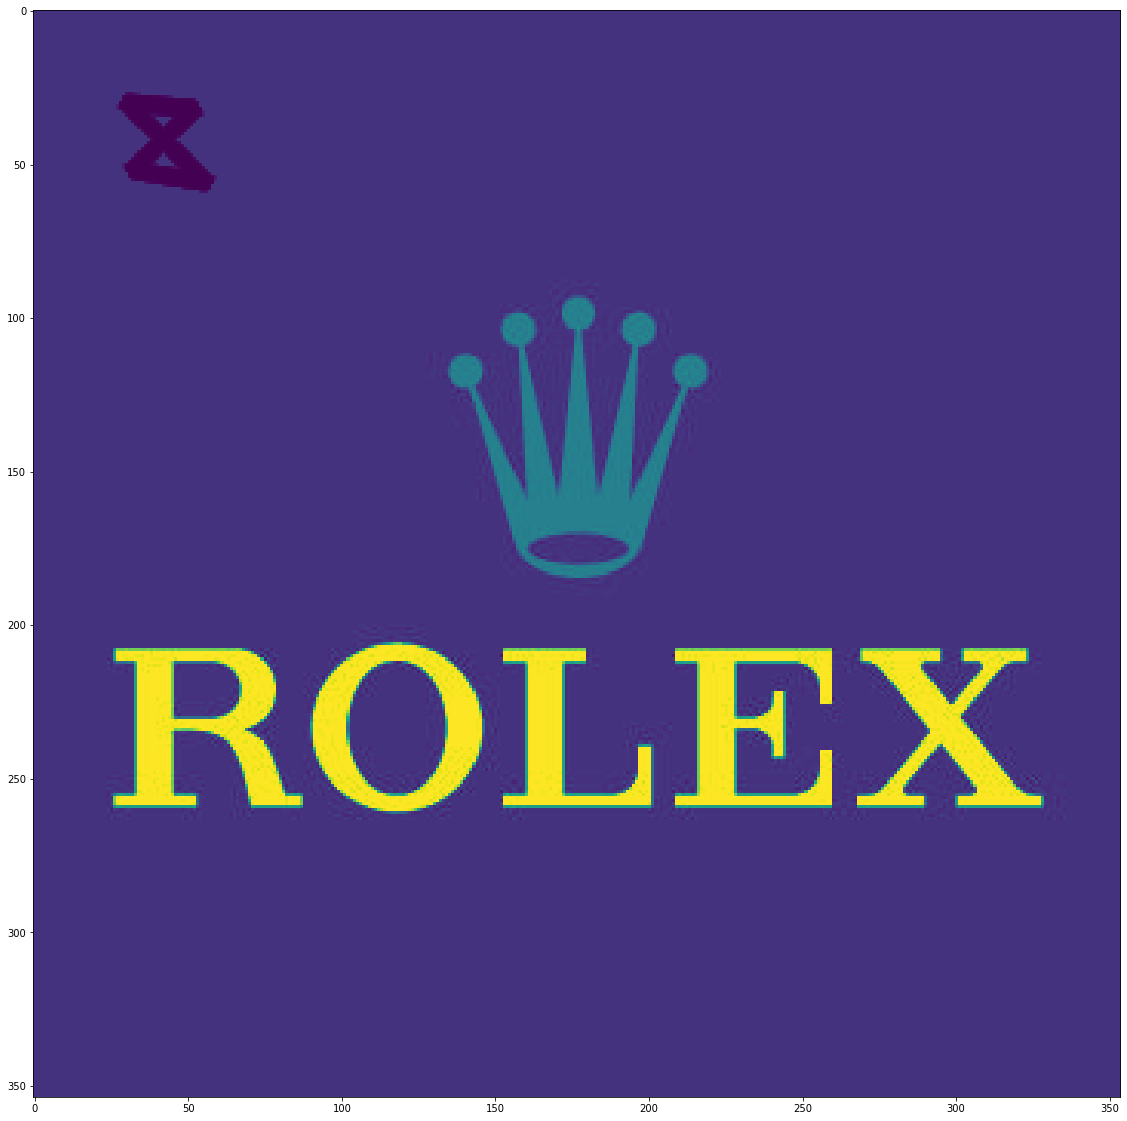

In [175]:
#TODO test cv2.polylines

# assumes pts are 4 points creating a closed quad
# electing to use list instead of BST or other varients since n=4 (finite, known, and very small)
def checkSimplePolygon(pts):
    # create 4 segments
    # sort the endpoints in each segment to have the smaller x value be first
    segs = [
            sorted([pts[0][0],pts[1][0]], key = lambda x: x[0]), 
            sorted([pts[1][0],pts[2][0]], key = lambda x: x[0]),
            sorted([pts[2][0],pts[3][0]], key = lambda x: x[0]),
            sorted([pts[3][0],pts[0][0]], key = lambda x: x[0])
           ]
    # sort all segments against each other using the starting endpoint's x value
    segs = sorted(segs, key = lambda x: x[0][0])
    
    processing = []
    
    while len(segs) > 0:
        new_seg = segs.pop(0)
        slope = (new_seg[0][1] - new_seg[1][1]) / (new_seg[0][0] - new_seg[1][0])
        for p in processing:
            if new_seg[0] in p or new_seg[1] in p or new_seg[0][0] > p[1][0] or new_seg[1][0] < p[0][0]:
                print(p)
                continue # coincident endpoints, these lines will not intersect again
            
            projected_y = (p[1][0]-new_seg[0][0]) * slope + new_seg[0][1]
                    
            if (new_seg[0][1] > p[0][1] and new_seg[1][1] < p[1][1] or
                new_seg[0][1] < p[0][1] and new_seg[1][1] > p[1][1]):
                pass
        processing.append(new_seg)
        
    print(processing)



testpoly = [[[30, 30]],
    [[52, 32]],
    [[32, 52]],
    [[56, 56]]]

test = cv2.polylines(img1,[np.int32(testpoly)],True,(0,255,0),3, cv2.LINE_AA)  

plt.figure(figsize=(20,20))
plt.imshow(test)

checkSimplePolygon(testpoly)
